In [ ]:
#@title Install some libs and export nvidia stuffs for torch.compile
!pip install --upgrade onnx onnxscript einops
!pip install onnxruntime-gpu --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

!wget https://github.com/camenduru/gperftools/releases/download/v1.0/libtcmalloc_minimal.so.4 -O libtcmalloc_minimal.so.4 -nc
%env LD_PRELOAD=libtcmalloc_minimal.so.4
%env LC_ALL="en_US.UTF-8"
%env LD_LIBRARY_PATH="/usr/lib64-nvidia:/usr/local/lib/python3.10/dist-packages/tensorrt_libs"
%env LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
!ldconfig /usr/lib64-nvidia
!ldconfig /usr/local/lib/python3.10/dist-packages/tensorrt_libs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.9/552.9 kB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 7.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.9/192.9 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.4 MB/s eta 0:00:00
--2024-02-29 08:54:55--  https://github.com/camenduru/gperftools/releases/download/v1.0/libtcmalloc_minimal.so.4
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/66

In [ ]:
#@title Install torch_tensorrt (Optional, takes about 5min)
!pip install torch_tensorrt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.4/18.4 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 111.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 M

In [ ]:
#@title Install OpenVINO (CPU, Optional)
!pip install openvino==2023.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 16.2 MB/s eta 0:00:00


In [ ]:
#@title Define some stuffs
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
import math

import torchvision
from IPython.display import display
from PIL import Image

import locale
locale.getpreferredencoding = lambda: "UTF-8"

to_pil = torchvision.transforms.ToPILImage()
to_tensor = torchvision.transforms.ToTensor()

def conv_layer(in_channels, out_channels, kernel_size):
    padding = int((kernel_size - 1) / 2)
    return nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)

class CReLU(nn.Module):
    def __init__(self):
        super(CReLU, self).__init__()

    def forward(self, x):
        return F.relu(torch.cat((x, -x), 1))

# Credit: https://github.com/kato-megumi
# block_depth: Num of hidden layer shaders + 1, must be >= num_feat
# num_feat: Total output channel of input Conv2D shaders
# stack_list = Num of binds of last_conv2d / 2
# last: last_conv2d's kernel=3 if True else 1
# single_tail: Set this to True if there is only 1 conv2d_last shader (e.g. Upscale_S, Upscale_M)
# Input conv2d shaders are first shaders having "MAIN_texOff", output conv2d shaders are last ones having "conv2d_last_tf"
class anime4k(nn.Module):
    def __init__(self, block_depth=7, stack_list=5, num_feat=12, last=False, scale=2, single_tail=False, upscale_mode="bilinear"):
        super(anime4k, self).__init__()
        self.act = CReLU()
        if type(stack_list) == int:
            stack_list = list(range(-stack_list, 0))
        self.stack_list = stack_list
        self.scale = scale
        self.ps = nn.PixelShuffle(self.scale)
        self.conv_head = conv_layer(3, num_feat, kernel_size=3)
        self.conv_mid = nn.ModuleList(
            [
                conv_layer(num_feat * 2, num_feat, kernel_size=3)
                for _ in range(block_depth - 1)
            ]
        )
        tail_out_c = 4 if single_tail else 3*scale*scale
        if last:
            self.conv_tail = conv_layer(2 * num_feat * len(stack_list), tail_out_c, kernel_size=3)
        else:
            self.conv_tail = conv_layer(2 * num_feat * len(stack_list), tail_out_c, kernel_size=1)
        self.upscale_mode = upscale_mode

    def forward(self, x):
        out = self.act(self.conv_head(x))
        depth_list = [out]
        for conv in self.conv_mid:
            out = self.act(conv(out))
            depth_list.append(out)
        out = self.conv_tail(torch.cat([depth_list[i] for i in self.stack_list], 1))
        if self.scale != 1:
            out = self.ps(out) + F.interpolate(x, scale_factor=self.scale, mode=self.upscale_mode)
        else:
            out += x
        return torch.clamp(out, max=1.0, min=0.0)

    def import_param(self, filename):
        for param in self.parameters():
            param.requires_grad = False
        with open(filename) as f:
            text = f.read()
        pattern = r'-?\d+(\.\d{4,})(e-?\d+)?'
        iter = re.finditer(pattern, text)
        convert(self.conv_head, iter)
        for conv in self.conv_mid:
            convert(conv, iter)
        convert(self.conv_tail, iter, True)
        check = next(iter, None)
        if check == None:
            print("pass")
        else:
            print("---failed---\n", check)


def convert(c, iter, doswap=False):
    swap = [0,2,1,3]
    out_chan, in_chan, width, height = c.weight.shape
    for to in range(math.ceil(out_chan/4)):
        for ti in range(math.ceil(in_chan/4)):
            for w in range(width):
                for h in range(height):
                    for i in range(min(4, in_chan)):
                        for o in range(min(4, out_chan)):
                            o = swap[o] if doswap else o
                            c.weight.data[to*4+o, ti*4+i, w, h] = float(next(iter).group(0))
        for o in range(min(4, out_chan)):
            o = swap[o] if doswap else o
            c.bias.data[to*4+o] = float(next(iter).group(0))

def get_luma(x):
    x = x[:, 0] * 0.299 + x[:, 1] * 0.587 + x[:, 2] * 0.114
    x = x.unsqueeze(1)
    return x

class MaxPoolKeepShape(nn.Module):
    def __init__(self, kernel_size, stride=None):
        super(MaxPoolKeepShape, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        kernel_height, kernel_width = self.kernel_size
        pad_height = (((height - 1) // self.stride + 1) - 1) * self.stride + kernel_height - height
        pad_width = (((width - 1) // self.stride + 1) - 1) * self.stride + kernel_width - width

        x = F.pad(x, (pad_width // 2, pad_width - pad_width // 2, pad_height // 2, pad_height - pad_height // 2))
        x = F.max_pool2d(x, kernel_size=self.kernel_size, stride=self.stride)
        return x

# Ref: https://github.com/bloc97/Anime4K/blob/master/glsl/Restore/Anime4K_Clamp_Highlights.glsl
class ClampHighlight(nn.Module):
    def __init__(self):
        super(ClampHighlight, self).__init__()
        self.max_pool = MaxPoolKeepShape(kernel_size=(5, 5), stride=1)
    def forward(self, shader_img, orig_img):
        curr_luma = get_luma(shader_img)
        statsmax = self.max_pool(get_luma(orig_img))
        if statsmax.shape != curr_luma.shape:
            statsmax = F.interpolate(statsmax, curr_luma.shape[2:4])
        new_luma = torch.min(curr_luma, statsmax)
        return shader_img - (curr_luma - new_luma)

class AutoDownscalePre(nn.Module):
    def __init__(self, factor, lower_thresh=1.2, upper_thresh=2.0, upscale_mode="bilinear"):
        super(AutoDownscalePre, self).__init__()
        self.factor = factor // 2
        self.lower_thresh = lower_thresh
        self.upper_thresh = upper_thresh
        self.upscale_mode = upscale_mode
    def forward(self, x, screen_width=1920, screen_height=1080):
        h, w = x.shape[2:]
        # RPN expression is so weird to understand. Let assume that ChatGPT is right
        # https://github.com/bloc97/Anime4K/blob/master/glsl/Upscale/Anime4K_AutoDownscalePre_x2.glsl#L30
        # https://github.com/bloc97/Anime4K/blob/master/glsl/Upscale/Anime4K_AutoDownscalePre_x4.glsl#L30
        h_ratio = h / screen_height / self.factor
        w_ratio = w / screen_width / self.factor
        if (h_ratio > self.lower_thresh) and \
           (w_ratio > self.lower_thresh) and \
           (h_ratio < self.upper_thresh) and \
           (w_ratio < self.upper_thresh):
           return F.interpolate(x, (screen_height // self.factor, screen_width // self.factor), mode=self.upscale_mode)
        return x

class Anime4KPipeline(nn.Module):
    def __init__(self, *models, screen_width=1920, screen_height=1080, final_stage_upscale_mode="bilinear"):
        super(Anime4KPipeline, self).__init__()
        self.models = list(models)
        self.screen_width = screen_width
        self.screen_height = screen_height
        self.final_stage_upscale_mode = final_stage_upscale_mode
    def to(self, device_or_dtype):
        for i in range(len(self.models)):
            self.models[i] = self.models[i].to(device_or_dtype)
        return self
    def half(self):
        return self.to(torch.half)
    def forward(self, x):
        clamp_hightlight, orig_img = None, None
        for model in self.models:
            if model.__class__.__name__ == "AutoDownscalePre":
                x = model(x, self.screen_width, self.screen_height)
                continue
            if model.__class__.__name__ == "ClampHighlight":
                clamp_hightlight = model
                orig_img = x.clone()
                continue
            x = model(x)
        if clamp_hightlight is not None:
            x = clamp_hightlight(x, orig_img)
        x = F.interpolate(x, (self.screen_height, self.screen_width), mode=self.final_stage_upscale_mode)
        return x

In [2]:
#@title Download shaders
!mkdir -p glsl
%cd glsl
from types import SimpleNamespace
sizes = ['S', 'M', 'L', 'VL', 'UL']
u_s_sizes = ['S', 'M', 'L', 'VL', 'UL']
restore_sizes = ['S', 'M', 'L', 'VL', 'UL']
restore_gan_sizes = ['UL', 'UUL']
restore_soft_sizes = ['S', 'M', 'L', 'VL', "UL"]
for size in sizes:
    !wget https://raw.githubusercontent.com/bloc97/Anime4K/master/glsl/Upscale/Anime4K_Upscale_CNN_x2_{size}.glsl -nc
for size in u_s_sizes:
    !wget https://raw.githubusercontent.com/bloc97/Anime4K/master/glsl/Upscale%2BDenoise/Anime4K_Upscale_Denoise_CNN_x2_{size}.glsl -nc
for size in restore_sizes:
    !wget https://raw.githubusercontent.com/bloc97/Anime4K/master/glsl/Restore/Anime4K_Restore_CNN_{size}.glsl -nc
for size in restore_gan_sizes:
    !wget https://raw.githubusercontent.com/bloc97/Anime4K/master/glsl/Restore/Anime4K_Restore_GAN_{size}.glsl -nc
for size in restore_soft_sizes:
    !wget https://raw.githubusercontent.com/bloc97/Anime4K/master/glsl/Restore/Anime4K_Restore_CNN_Soft_{size}.glsl -nc
%cd ..

model_dict = {
    "Upscale_S": ("/content/glsl/Anime4K_Upscale_CNN_x2_S.glsl", 3, 1, 4, True, 2, True),
    "Upscale_M": ("/content/glsl/Anime4K_Upscale_CNN_x2_M.glsl", 7, 7, 4, False, 2, True),
    "Upscale_L": ("/content/glsl/Anime4K_Upscale_CNN_x2_L.glsl", 3, 1, 8, True, 2),
    "Upscale_VL": ("/content/glsl/Anime4K_Upscale_CNN_x2_VL.glsl", 7, 7, 8, False, 2),
    "Upscale_UL": ("/content/glsl/Anime4K_Upscale_CNN_x2_UL.glsl", 7, 5, 12, False, 2),
    "Upscale_Denoise_S": ("/content/glsl/Anime4K_Upscale_Denoise_CNN_x2_S.glsl", 3, 1, 4, True, 2, True),
    "Upscale_Denoise_M": ("/content/glsl/Anime4K_Upscale_Denoise_CNN_x2_M.glsl", 7, 7, 4, False, 2, True),
    "Upscale_Denoise_L": ("/content/glsl/Anime4K_Upscale_Denoise_CNN_x2_L.glsl", 3, 1, 8, True, 2),
    "Upscale_Denoise_VL": ("/content/glsl/Anime4K_Upscale_Denoise_CNN_x2_VL.glsl", 7, 7, 8, False, 2),
    "Upscale_Denoise_UL": ("/content/glsl/Anime4K_Upscale_Denoise_CNN_x2_UL.glsl", 7, 5, 12, False, 2),
    "Restore_S": ("/content/glsl/Anime4K_Restore_CNN_S.glsl", 3, 1, 4, True, 1),
    #"Restore_M": ("/content/glsl/Anime4K_Restore_CNN_M.glsl", 7, 7, 4, False, 1), Doesn't work for some reason
    "Restore_L": ("/content/glsl/Anime4K_Restore_CNN_L.glsl", 4, 1, 8, True, 1),
    "Restore_VL": ("/content/glsl/Anime4K_Restore_CNN_VL.glsl", 8, 7, 8, False, 1),
    "Restore_UL": ("/content/glsl/Anime4K_Restore_CNN_UL.glsl", 8, 5, 12, False, 1),
    "Restore_Soft_S": ("/content/glsl/Anime4K_Restore_CNN_Soft_S.glsl", 3, 1, 4, True, 1),
    "Restore_Soft_M": ("/content/glsl/Anime4K_Restore_CNN_Soft_M.glsl", 7, 7, 4, False, 1),
    "Restore_Soft_L": ("/content/glsl/Anime4K_Restore_CNN_Soft_L.glsl", 4, 1, 8, True, 1),
    "Restore_Soft_VL": ("/content/glsl/Anime4K_Restore_CNN_Soft_VL.glsl", 8, 7, 8, False, 1),
    "Restore_Soft_UL": ("/content/glsl/Anime4K_Restore_CNN_Soft_UL.glsl", 8, 5, 12, False, 1)
}

def create_model(name, upscale_mode="bilinear"):
    filename, *model_params = model_dict[name]
    model = anime4k(*model_params, upscale_mode=upscale_mode)
    model.import_param(filename)
    return model

/root/anime4k-cog/glsl
--2025-09-14 02:35:15--  https://raw.githubusercontent.com/bloc97/Anime4K/master/glsl/Upscale/Anime4K_Upscale_CNN_x2_S.glsl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18638 (18K) [text/plain]
Saving to: ‘Anime4K_Upscale_CNN_x2_S.glsl’

Anime4K_Upscale_CNN 100%[===================>]  18.20K  --.-KB/s    in 0s      

2025-09-14 02:35:15 (141 MB/s) - ‘Anime4K_Upscale_CNN_x2_S.glsl’ saved [18638/18638]

--2025-09-14 02:35:16--  https://raw.githubusercontent.com/bloc97/Anime4K/master/glsl/Upscale/Anime4K_Upscale_CNN_x2_M.glsl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443...

In [ ]:
#@title Create pipeline and warmup
USE_FP16 = True #@param {type:"boolean"}
OPTIMIZATION = "None" #@param ["TorchDynamo", "Torch-TensorRT", "OpenVINO", "None"]
#@markdown Change arguments passing to Anime4KPipeline to implement another preset.
#@markdown For example, preset A (HQ) is
#@markdown ```
#@markdown ~~/shaders/Anime4K_Clamp_Highlights.glsl;~~/shaders/Anime4K_Restore_CNN_VL.glsl;~~/shaders/Anime4K_Upscale_CNN_x2_VL.glsl;~~/shaders/Anime4K_AutoDownscalePre_x2.glsl;~~/shaders/Anime4K_AutoDownscalePre_x4.glsl;~~/shaders/Anime4K_Upscale_CNN_x2_M.glsl
#@markdown ```
#@markdown can be implemented as the predefined pipeline. `screen_width` and `screen_height` are size of output images
#@markdown <br> @TODO: Add video support

import einops

#Implementation of preset A (HQ)
pipeline = Anime4KPipeline(
    ClampHighlight(),
    create_model("Upscale_Denoise_VL"),
    AutoDownscalePre(4),
    create_model("Upscale_M"),
    screen_width=1920, screen_height=1080,
    final_stage_upscale_mode = "bilinear"
)

if OPTIMIZATION == "TorchDynamo":
    torch._inductor.config.conv_1x1_as_mm = True
    #torch._inductor.config.coordinate_descent_tuning = True
    torch._inductor.config.epilogue_fusion = False
    #torch._inductor.config.coordinate_descent_check_all_directions = True
    torch._inductor.config.use_mixed_mm = True
    device = "cuda"
    if USE_FP16:
        pipeline = pipeline.to(device).half()
    pipeline = torch.compile(pipeline, mode="reduce-overhead")
elif OPTIMIZATION == "OpenVINO":
    import openvino.torch
    pipeline = torch.compile(pipeline, backend="openvino")
    device = "cpu"
elif OPTIMIZATION == "Torch-TensorRT":
    import torch_tensorrt
    device = "cuda"
    rand_image = torch.rand(1, 3, 720, 1280).to(device)
    if USE_FP16:
        pipeline = pipeline.to(device).half()
        rand_image = rand_image.half()
    #Is this legal?
    pipeline = torch.compile(torch.jit.script(torch.jit.trace(pipeline, rand_image)), backend="tensorrt")
else:
    device = "cuda"
    if USE_FP16:
        pipeline = pipeline.to(device).half()

def timed(fn):
    if torch.cuda.is_available():
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()
        result = fn()
        end.record()
        torch.cuda.synchronize()
        return result, start.elapsed_time(end) / 1000
    else:
        from time import perf_counter
        start = perf_counter()
        result = fn()
        end = perf_counter()
        return result, end - start
rand_image = torch.rand(1, 3, 720, 1280).to(device)
if USE_FP16:
    rand_image = rand_image.half()
pipeline(rand_image)
for _ in range(20):
    _, t = timed(lambda: pipeline(rand_image))
    print(t * 1000, 'ms')

pass
pass
97.18370819091797 ms
69.07904052734375 ms
67.3076171875 ms
69.10336303710938 ms
68.136962890625 ms
67.25228881835938 ms
67.82777404785156 ms
68.15094757080078 ms
67.6860122680664 ms
68.06527709960938 ms
67.98191833496094 ms
67.85874938964844 ms
67.59664154052734 ms
68.04688262939453 ms
68.80850982666016 ms
71.15907287597656 ms
67.43043518066406 ms
68.65337371826172 ms
67.88301086425781 ms
68.2033920288086 ms


In [ ]:
#@title Export to onnx (Require OPTIMIZATION=None)
onnx_filename = "pipeline_preset_C.onnx" #@param {"type": "string"}
torch.onnx.export(pipeline, rand_image, onnx_filename, input_names=["input"])

<ipython-input-5-41ada0a6e1c5>:154: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if (h_ratio > self.lower_thresh) and \
<ipython-input-5-41ada0a6e1c5>:135: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if statsmax.shape != curr_luma.shape:


In [ ]:
for c in ['A', 'B', 'C']:
    !mv pipeline_preset_{c}.onnx drive/MyDrive

/bin/bash: warning: setlocale: LC_ALL: cannot change locale ("en_US.UTF-8")
/bin/bash: warning: setlocale: LC_ALL: cannot change locale ("en_US.UTF-8")
/bin/bash: warning: setlocale: LC_ALL: cannot change locale ("en_US.UTF-8")


## Inference with Onnxruntime + TensorRT

In [ ]:
#@title Create session, takes about 7min for compiling engine
import onnxruntime as ort
import numpy as np
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!mkdir /content/trt_cache
onnx_filename = "pipeline_preset_A.onnx" #@param {"type": "string"}
use_fp16 = True #@param {"type": "boolean"}
ort_session = ort.InferenceSession(onnx_filename, providers=[
    (
        "TensorrtExecutionProvider",
        { "trt_fp16_enable": use_fp16 },
    ),
    "CUDAExecutionProvider",
    "CPUExecutionProvider",
])



mkdir: cannot create directory ‘/content/trt_cache’: File exists


In [ ]:
from time import perf_counter
inp = np.random.randn(5, 3, 720, 1280).astype(np.float16)
for _ in range(20):
    start = perf_counter()
    outputs = ort_session.run(
        None,
        {"input": inp},
    )
    print((perf_counter() - start) * 1000, 'ms')

89.41321999918728 ms
89.68387499953678 ms
60.896323000633856 ms
60.553823999725864 ms
60.09834599990427 ms
59.88572499973088 ms
60.08760799977608 ms
59.513771999263554 ms
59.77539299965429 ms
60.65518399918801 ms
59.546790000240435 ms
59.976915000333975 ms
59.62666400046146 ms
59.410819999357045 ms
59.814903999722446 ms
59.93849100013904 ms
59.94360400018195 ms
59.95456300024671 ms
59.808516999510175 ms
59.46118500014563 ms


## PyTorch Inference

File ‘6486130.jpg’ already there; not retrieving.

64.78441619873047 ,s


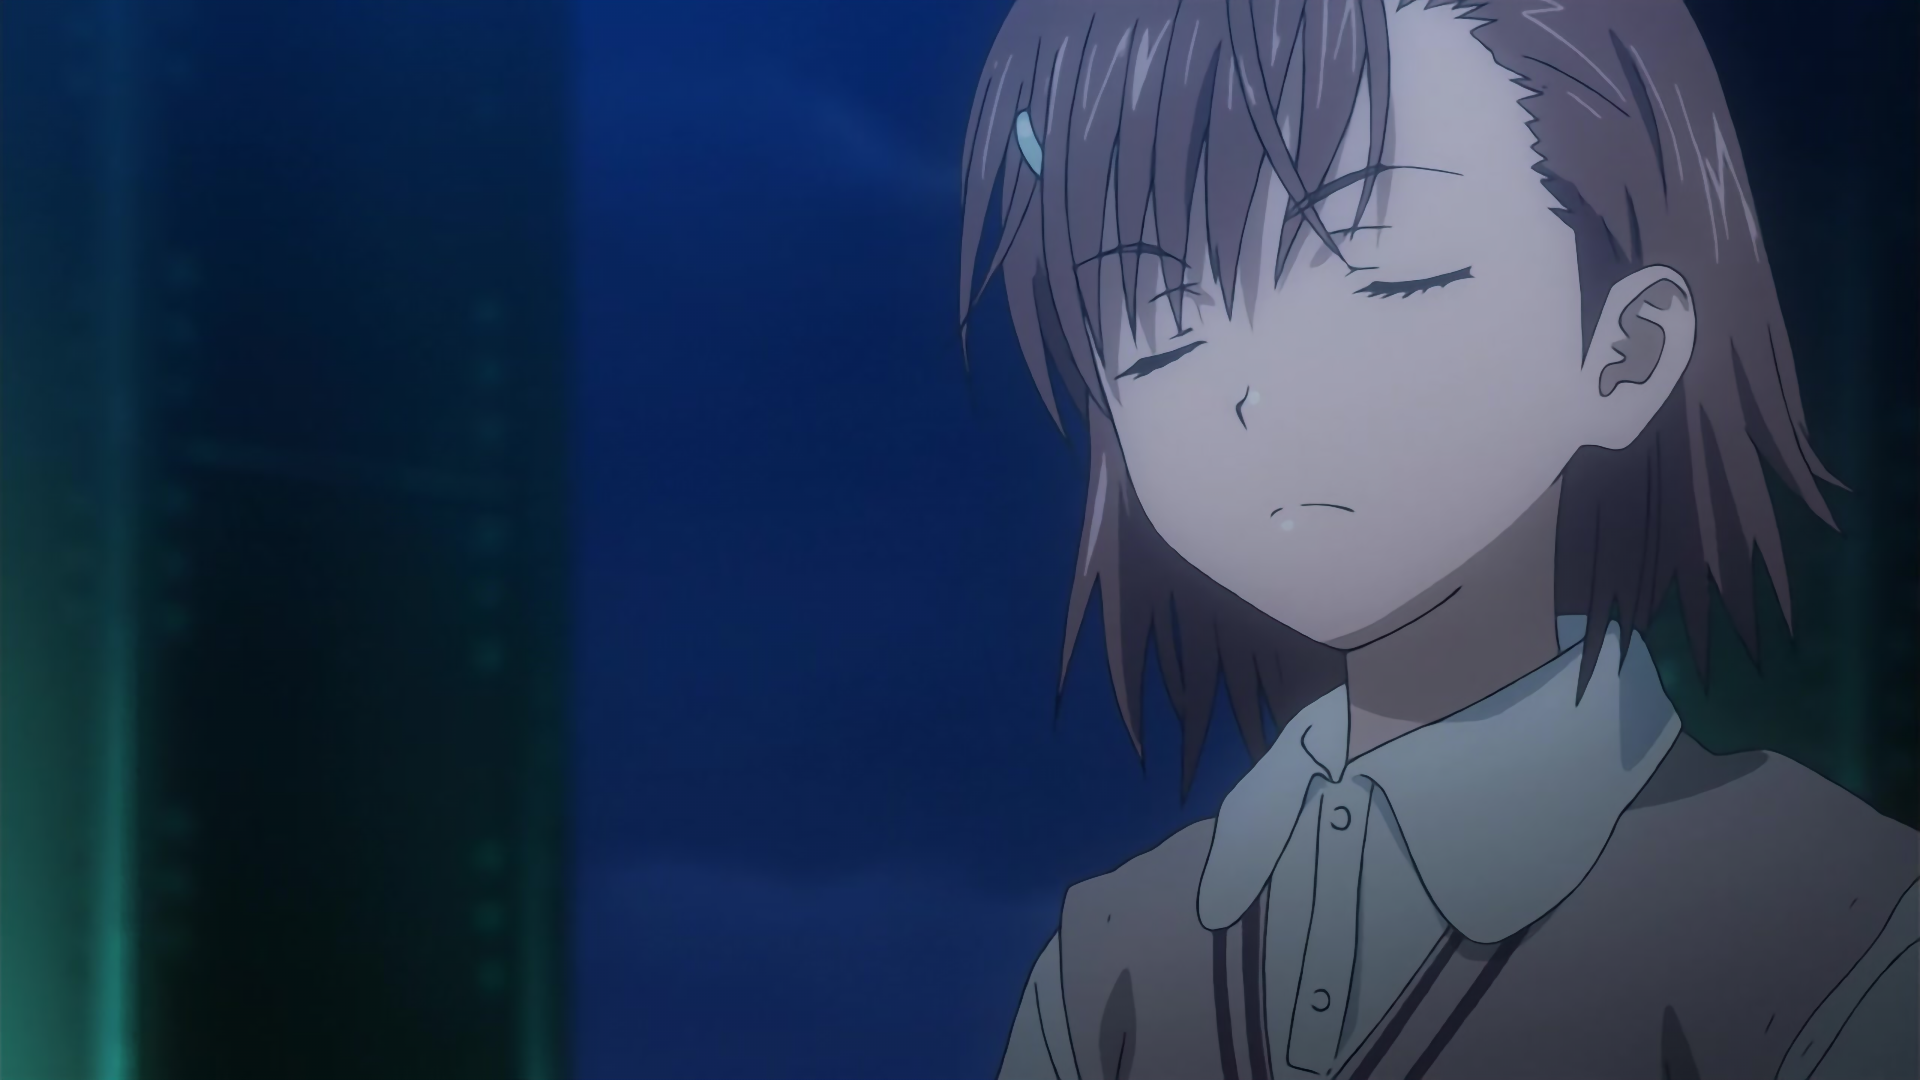

In [ ]:
from einops import repeat
!wget https://cdni.fancaps.net/file/fancaps-animeimages/6486130.jpg -nc
image = to_tensor(Image.open("6486130.jpg").convert("RGB")).unsqueeze(0).to(device)
if USE_FP16:
    image = image.half()
for _ in range(5):
    out, t = timed(lambda: pipeline(image))
print(t * 1000, ',s')
display(to_pil(out[0]))